## This notebook is for an example of how to use XCast for making multimodel ensemble using Extreme Learning Machine methods for determinisitc and Probabilisitc  forecast.

Prediction surface temperature for this example using two NMME model and GCHN data as reference

Created by Nachiketa Acharya on Oct,2023

Reference:

Acharya et al., 2014;https://link.springer.com/article/10.1007/s00382-013-1942-2)

Acharya and Hall 2023:http://103.215.208.102/index.php/MAUSAM/article/view/5997



### Import Librarires

In [1]:
import xcast as xc 
import xarray as xr 
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import utils_updated as utils

Showing the version of XCast installed

In [ ]:
xc.__version__

In [ ]:
obs = xr.open_dataset('/Users/bohar/Documents/X-cast/data/ECMWF/CHIRPS_trainig_2003-2015.nc',decode_times=False)
obs

### Read downloded Observed data


Read your donwloded or own observed data. For example, I have donwloeded GCHN data(JJAS avaergare from 1982-2022 for 12-72N,60-170W)Y 
from IRI DL using the below link.However,anyone can donwloded data from any webpage
data downlowed from IRI data library link :https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GHCN_CAMS/.1x1_4822/.t2m/T/%28Jan%201982%29/%28Dec%202022%29/RANGE/T/%28Jun-Aug%29/seasonalAverage/Y/%2812N%29/%2872N%29/RANGEEDGES/X/%28170W%29/%2860W%29/RANGEEDGES/273/add/index.html#expert

In [3]:
obs = xr.open_dataset('/Users/bohar/Documents/X-cast/data/ECMWF/CHIRPS_trainig_2003-2015.nc',decode_times=False).prcp.expand_dims({'M':[0]},axis=1)#As XCast handle only 4 dimesion data, we need to add one extra dimesion in Observed data. Here, we add "M" dimension in second axis. This is only for data downloded from IRI Data library as they have this issue
obs.shape

(117, 1, 23, 21)

In [4]:
obs_test = xr.open_dataset('/Users/bohar/Documents/X-cast/data/ECMWF/CHIRPS_test_2015-2022.nc',decode_times=False).prcp.expand_dims({'M':[0]},axis=1)#As XCast handle only 4 dimesion data, we need to add one extra dimesion in Observed data. Here, we add "M" dimension in second axis. This is only for data downloded from IRI Data library as they have this issue
obs_test.shape

(63, 1, 23, 21)

### Read downloded NMME data

Read your donwloded NMME data from anywhere.For example, I have donwloeded GCHN data(lead -1,May Start JJAS avaergare from 1982-2022 for 12-72N,60-170W) from IRI DL using the below links.However,anyone can donwloded data from any webpage data downlowed from IRI data library link

data downlowed links :

CFS:https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/a:/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.tref/:a:/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.tref/:a/appendstream/S/%280000%201%20May%201982-2021%29/VALUES/L/0.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/%2812N%29/%2872N%29/RANGEEDGES/X/%28170W%29/%2860W%29/RANGEEDGES/M/%281%29/%2824%29/RANGE/%5BM%5Daverage/index.html#expert


In [5]:
model1 = xr.open_dataset('/Users/bohar/Documents/X-cast/data/ECMWF/ECMWF_training_2003-2015.nc',decode_times=False).ratio

model1= model1.rename({'L':'M'})

#model1 =model1.expand_dims({'M':[0]},axis=1)
#model2 = xr.open_dataset('CCSM4_MayIC_JJA_1982_2021_tref.nc',decode_times=False).tref.squeeze('Z')# it has extra Z axis

#model2= model2.rename({'L':'M'})
#model2.dims

predictor_names=['ECMWF']

Model = xr.concat([model1], 'M').assign_coords({'M': predictor_names})
Model.shape
#Model1

(117, 1, 23, 21)

In [6]:
#model1.values

In [7]:
model1 = xr.open_dataset('/Users/bohar/Documents/X-cast/data/ECMWF/ECMWF_test_2016-2022.nc',decode_times=False).ratio
model1= model1.rename({'L':'M'})

predictor_names=['ECMWF']

Model_test = xr.concat([model1], 'M').assign_coords({'M': predictor_names})
Model_test.shape
#Model1

(63, 1, 23, 21)

### Match the resolution of Model and Observed data

In [8]:
#Model,obs = xc.match(Model,obs)

In [95]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs_test)
T = ohc.transform(obs_test)
clim = xr.ones_like(T) * 0.333


### MME fitting with Extreem Learning Machine and Probabilisitc Extreem Learning Machine

#### Fit and forecast with ELM

In [96]:
elm_kwargs = {
            'regularization': 10,
            'hidden_layer_size': 5,
            'activation': 'lin',# 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
            'preprocessing':'minmax',#minmax', 'std', 'none' ],
            'n_estimators': 1000,
}

# Run fitting and forecast

hindcasts_det, hindcasts_prob = [], []
reg = xc.ELM(**elm_kwargs)
reg.fit(Model, obs)
preds = reg.predict(Model_test)
probs =  reg.predict_proba(Model_test)
elm_hindcasts_det = preds
elm_hindcasts_prob = probs

#### Fit and Forecast with CCA

In [97]:
#Define hyparameter
cca = xc.CCA(
  xmodes=(1, 5), 
  ymodes=(1, 5), 
  ccamodes=(1,5), 
  crossvalidation_splits='auto',
  probability_method='error_variance', 
  latitude_weighting=None,
  search_override=(None, None, None)
)
# fit
cca.fit(Model, obs) 
#prediction 
cca_deterministic_preds = cca.predict(Model_test)
cca_tercile_probabilities = cca.predict_proba(Model_test) 

#### Fit and forecast with PCR

In [98]:
#pcr = xc.PCR(
#  eof_modes=None,  # integer number of EOF modes to use - if none, use min(n_samples, m_features) 
#  latitude_weighting=False,  # latitude weighting? yes or no
#  separate_members=True,  # whether or not to calculate principal components of X features jointly (stacking them all as equally weighted features) or separately.
#  crossvalidation_splits=5, # number of splits to use for K-Fold cross validation
#)
#fit PCR model
#pcr.fit(Model, obs)
# prediction with PCR
#deterministic_preds_pcr = pcr.predict(Model_test)
#tercile_probabilities_pcr = pcr.predict_proba(Model) 


#### Fit and forecast with PCR

In [101]:
reg = xc.ELR()
reg.fit(Model, obs)
elr_probs =  reg.predict_proba(Model_test)

/Users/bohar/anaconda3/envs/xcast_env/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


#### Fit and forecast with QRF

In [102]:
# initiate QRF object with defalut hyper parameters
qrf = xc.QRF()
qrf.fit(Model, obs) 
qrf_preds = qrf.predict(Model_test)
qrf_probs =  qrf.predict_proba(Model_test)

 ## Skill comparison 

#### Spearman Correlation 

In [103]:
pearson_elm = xc.Pearson(elm_hindcasts_det, obs_test)
pearson_cca = xc.Pearson(cca_deterministic_preds, obs_test)
pearson_qrf = xc.Pearson(qrf_preds, obs_test)

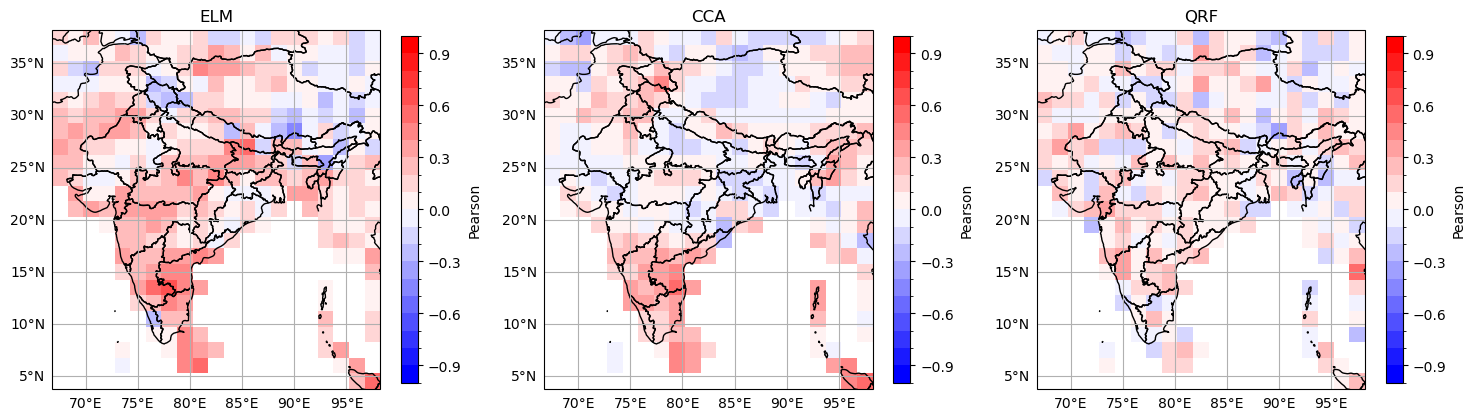

In [104]:
fig = plt.figure(figsize=(18,5),projection=ccrs.PlateCarree())
#subplot 1
ax1 = fig.add_subplot(1, 3, 1,projection=ccrs.PlateCarree())
#ax1.set_title("ELM", fontsize='small')
pearson_elm.plot( vmin=-1, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='bwr')
ax1.set_title('ELM')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#subplot 2
ax1 = fig.add_subplot(1, 3, 2,projection=ccrs.PlateCarree())
pearson_cca.plot( vmin=-1, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='bwr')
ax1.set_title('CCA')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#subplot 3
ax1 = fig.add_subplot(1, 3, 3,projection=ccrs.PlateCarree())
pearson_qrf.plot( vmin=-1, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='bwr')
ax1.set_title('QRF')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

##### GROC

In [105]:
elm_groc=xc.GROCS(elm_hindcasts_prob, T)
elr_groc=xc.GROCS(elr_probs, T)
cca_groc=xc.GROCS(cca_tercile_probabilities, T)
qrf_groc=xc.GROCS(qrf_probs, T)

/Users/bohar/anaconda3/envs/xcast_env/lib/python3.11/site-packages/xcast-0.6.9-py3.9.egg/xcast/verification/flat_metrics.py:56: RuntimeWarning: invalid value encountered in divide


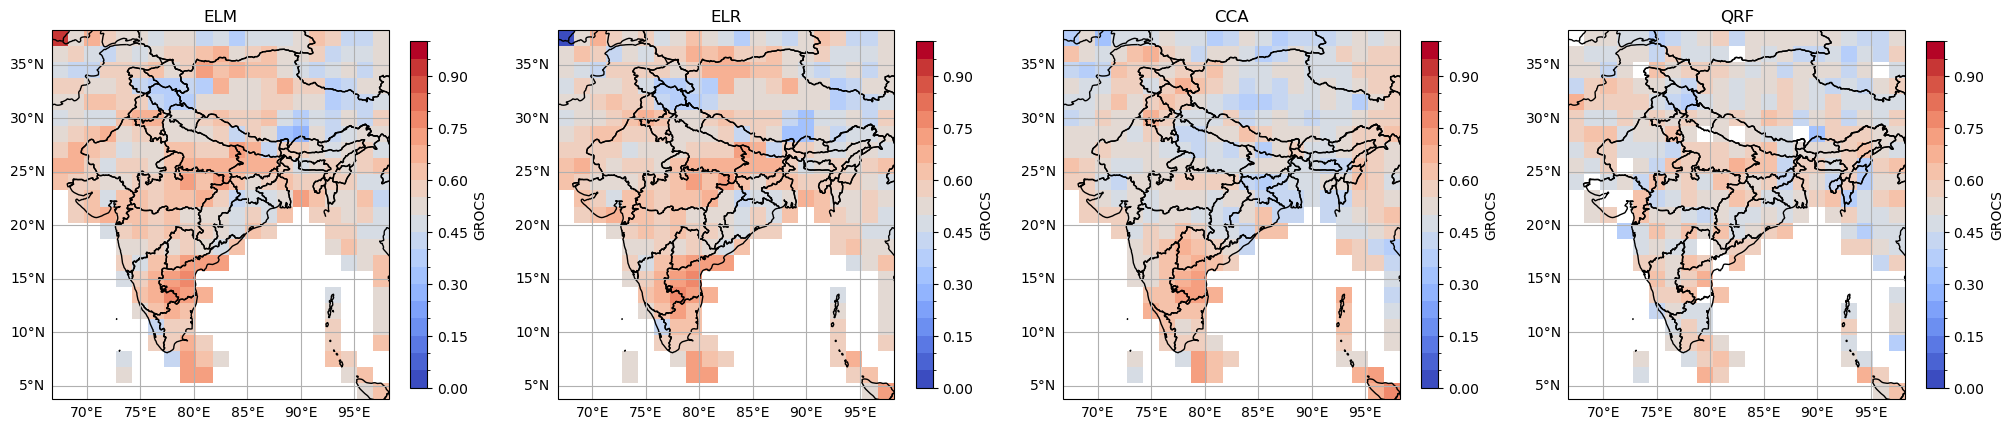

In [110]:
fig = plt.figure(figsize=(25,5))
#subplot 1
ax1 = fig.add_subplot(1, 4, 1,projection=ccrs.PlateCarree())
#ax1.set_title("ELM", fontsize='small')
elm_groc.plot( vmin=0, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='coolwarm')
ax1.set_title('ELM')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#subplot 2
ax1 = fig.add_subplot(1, 4, 2,projection=ccrs.PlateCarree())
#ax1.set_title("ELM", fontsize='small')
elr_groc.plot( vmin=0, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='coolwarm')
ax1.set_title('ELR')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
ax.add_feature(cf.COASTLINE)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#subplot 3
ax1 = fig.add_subplot(1, 4, 3,projection=ccrs.PlateCarree())
#ax1.set_title("ELM", fontsize='small')
cca_groc.plot( vmin=0, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='coolwarm')
ax1.set_title('CCA')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
ax.add_feature(cf.COASTLINE)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#subplot 4
ax1 = fig.add_subplot(1, 4, 4,projection=ccrs.PlateCarree())
#ax1.set_title("ELM", fontsize='small')
qrf_groc.plot( vmin=0, vmax=1, cbar_kwargs={'shrink': 0.9},levels=21,cmap='coolwarm')
ax1.set_title('QRF')
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
ax.add_feature(cf.COASTLINE)
gl =ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False